In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import itertools as it
import networkx as nx
import random

1)

In [174]:
def analizar_grafo(grafo):
    componentes_conexas = [x for x in nx.connected_components(grafo)]
    tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

    print("Cantidad de nodos: {0}".format(grafo.number_of_nodes()))
    print("Cantidad de aristas: {0}".format(grafo.number_of_edges()))
    print("Cantidad de componentes conexas: ", len(componentes_conexas))
    print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    G = grafo.subgraph(tupla_componente_gigante[0])
    #print(type(G))
    
    print("Segunda Componente :")
    segunda = grafo.copy()
    segunda.remove_nodes_from(G)
    if segunda.number_of_nodes() > 0 :
        componentes_conexas = [x for x in nx.connected_components(segunda)]
        tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

        print("Cantidad de nodos: {0}".format(segunda.number_of_nodes()))
        print("Cantidad de aristas: {0}".format(segunda.number_of_edges()))
        print("Cantidad de componentes conexas: ", len(componentes_conexas))
        print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    return G

In [157]:
G = nx.Graph()

with open('./data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        autores = [autor.strip() for autor in row[3].split('&')]
        coautorias = it.combinations(autores, 2)
        G.add_edges_from(coautorias)


In [175]:
analizar_grafo(G)

Cantidad de nodos: 3698
Cantidad de aristas: 7880
Cantidad de componentes conexas:  236
Cantidad de nodos de la componente conexa gigante:  3018
Segunda Componente :
Cantidad de nodos: 680
Cantidad de aristas: 611
Cantidad de componentes conexas:  235
Cantidad de nodos de la componente conexa gigante:  18


In [95]:
nx.draw(G)

TypeError: 'module' object is not callable

2)

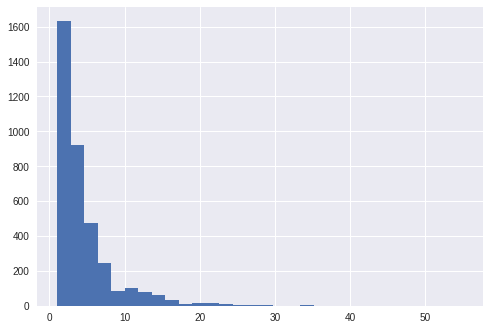

In [4]:
grados = list(nx.degree(G).values())
count, bins, patches = plt.hist(grados, bins=30)
plt.show()

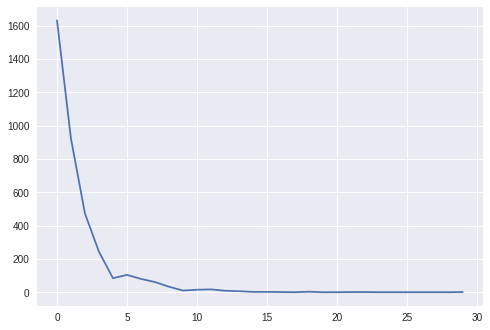

In [5]:
plt.plot(count)

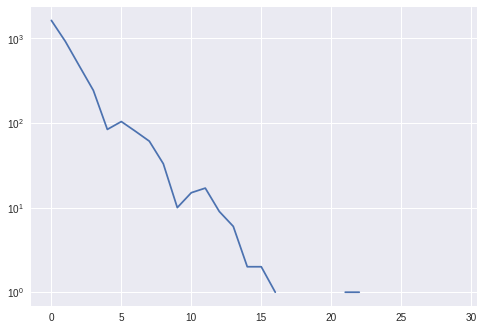

In [6]:
plt.semilogy(count)

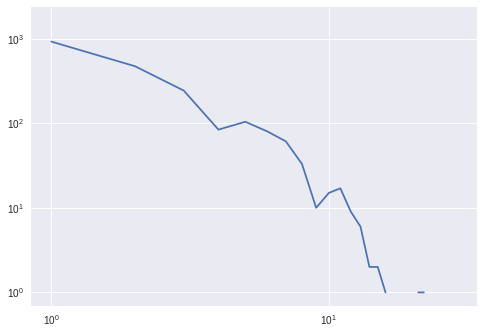

In [7]:
plt.loglog(count)

3)

In [8]:
componentes_conexas = [x for x in nx.connected_components(G)]

tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

print("cantidad de componentes conexas: ", len(componentes_conexas))
print("componente conexa gigante: ", tupla_componente_gigante[1])

cantidad de componentes conexas:  236
componente conexa gigante:  3018


4)

In [19]:
componente_gigante = G.subgraph(tupla_componente_gigante[0])

all_distances = nx.all_pairs_shortest_path_length(componente_gigante)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [22]:

print(all_distances.keys())

dict_keys(['Eholzer', 'Aratyn', 'Cheung', 'Alcaraz', 'Prades', 'Kovner', 'Ramadevi', 'Consoli', 'Wilczek', 'Dey', 'Sachdev', 'Teixeira', 'Veneziano', 'Lozano', 'Kamenshchik', 'Aida', 'Ishihara', 'Nagai', 'Baver', 'Volovik', 'Louko', 'Forge', 'Galajinsky', 'Talavera', 'Bralic', 'Lazzizzera', 'Pioline', 'Zlatev', 'Nguyen', 'Evans', 'Jaimungal', 'Sugino', 'Sparano', 'bougourzi', 'Burwick', 'Dolan', 'Cardy', 'Weiss', 'Plata', 'Piran', 'Hirota', 'de Santos', 'Philippides', 'Stedman', 'Aste', 'Uranga', 'Burkardt', 'Manvelyan', 'Roditi', 'Bass', 'Dudas', 'Lewis', 'Polyubin', 'Miki', 'Kalmykov', 'Rajeev', 'Cowdall', 'Gava', 'Shariati', 'Rozenberg', 'McCarthy', 'Dragon', 'Berkovich', 'Bershadsky', 'Gorbar', 'Bonora', 'Felipe', 'Fiola', 'Mukherjee', 'Vassilevich', 'Rey', 'Heinz', 'Rajagopal', 'REY', 'Sakmaoto', 'Jhingan', 'Sivakumar', 'Odintsov', 'Gangopadhyaya', 'Cecotti', 'Baxter', 'Hamada', 'Perevalov', 'Pashnev', 'Dimakis', 'Kobdaj', 'Kiem', 'Itoyama', 'Skorik', 'Mulvey', 'Hockney', 'Kleiss'

In [11]:
def invert_map(map):
    inv_map = {}
    for k, v in map.items():
        inv_map.setdefault(v, [])
        inv_map[v].append(k)
    return inv_map

def authors_by_distance(componente_gigante):
    nodo_raiz_idx = random.randint(0, len(componente_gigante) - 1)
    nodo_raiz = componente_gigante.nodes()[nodo_raiz_idx]

    paths = invert_map(all_distances[nodo_raiz])
    diferencial = {}
    
    previous_quantity = 0
    for distance in sorted(paths.keys()):
        diferencial[distance] = len(paths[distance]) 
        
    return diferencial

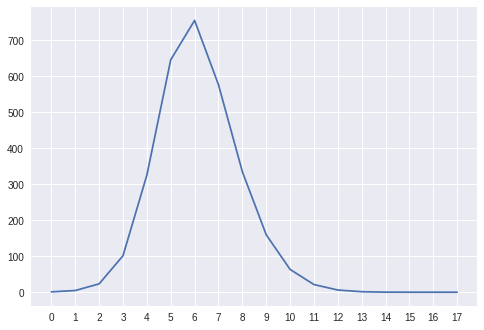

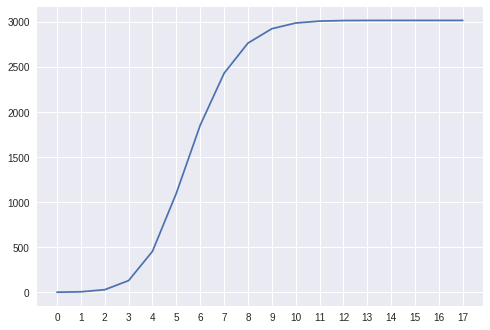

In [13]:
componente_gigante = G.subgraph(tupla_componente_gigante[0])

all_distances = nx.all_pairs_shortest_path_length(componente_gigante)

iterations = 2000
longest_path = max([max(node_distances.values()) for node_distances in all_distances.values()]) + 1
results = np.zeros((iterations, longest_path), dtype=int)

for iteration in range(iterations):
    diferencial = authors_by_distance(componente_gigante)
    
    for distance, quantity in diferencial.items():
        results[iteration, distance] = quantity

diferencial_means = results.mean(axis=0)
incremental_means = []

previous_quantity = 0
for quantity in diferencial_means:
    incremental_means.append(quantity + previous_quantity)
    previous_quantity = quantity + previous_quantity

def plot(y):
    sns.plt.figure()
    sns.plt.xticks(range(longest_path+1))
    sns.plt.plot(range(longest_path),y)


plot(diferencial_means)
plot(incremental_means)

5)

In [42]:
clustering = nx.average_clustering(componente_gigante)
avg_shortest_path_length = nx.average_shortest_path_length(componente_gigante)

degrees_seq = list(dict(componente_gigante.degree()).values())
# Hago un grafo aleatorio con la distribución de grados
GR = nx.configuration_model(degrees_seq, create_using=nx.Graph(G))

clustering_random = nx.average_clustering(GR)

In [43]:
print(nx.Graph(GR))
print(clustering_random)

configuration_model 3018 nodes 7257 edges
0.003422027497984325


In [47]:
clustering = nx.average_clustering(componente_gigante)
avg_shortest_path_length = nx.average_shortest_path_length(componente_gigante)

degrees_seq = list(dict(componente_gigante.degree()).values())
# Hago un grafo aleatorio con la distribución de grados
GR = nx.configuration_model(degrees_seq, create_using=nx.Graph())


#Me quedo con la componente conexa más grande del grafo aleatoreo
componentes_conexas = [x for x in nx.connected_components(GR)]
tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

random_G = GR.subgraph(tupla_componente_gigante[0])
print(nx.Graph(random_G))

clustering_random = nx.average_clustering(random_G)
avg_shortest_path_length_random = nx.average_shortest_path_length(random_G)

print('Grafo componente gigante:')
print('\tClustering: {0}'.format(clustering))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length))

print(u'Grafo aleatorio con la misma distribución:')
print('\tClustering: {0}'.format(clustering_random))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length_random))

configuration_model 3018 nodes 7255 edges
Grafo componente gigante:
	Clustering: 0.4840014369969915
	Camino minimo medio: 6.131037221593651
Grafo aleatorio con la misma distribución:
	Clustering: 0.004139003212276773
	Camino minimo medio: 4.7608638058361015


6)

In [176]:
def analizar_centralidad(grafo, repeticiones, degree):
    completo = grafo.copy()
    
    for i in range(repeticiones):
        print("iteracion: ", i)
        componente_gigante = analizar_grafo(completo)
        
        if degree :
            degree_centralty = nx.degree_centrality(componente_gigante)
        else :
            betweenness_centralty = nx.betweenness_centrality(componente_gigante)
        
        if degree :
            important_node = max(degree_centralty.items(), key=operator.itemgetter(1))[0]
        else :
            important_node = max(betweenness_centralty.items(), key=operator.itemgetter(1))[0]
        
        completo.remove_node(important_node)
        print()
       
    print()
    analizar_grafo(completo)

In [178]:
analizar_centralidad(componente_gigante,1000,True)

iteracion:  0
Cantidad de nodos: 3018
Cantidad de aristas: 7269
Cantidad de componentes conexas:  1
Cantidad de nodos de la componente conexa gigante:  3018
Segunda Componente :

iteracion:  1
Cantidad de nodos: 3017
Cantidad de aristas: 7215
Cantidad de componentes conexas:  5
Cantidad de nodos de la componente conexa gigante:  3013
Segunda Componente :
Cantidad de nodos: 4
Cantidad de aristas: 0
Cantidad de componentes conexas:  4
Cantidad de nodos de la componente conexa gigante:  1

iteracion:  2
Cantidad de nodos: 3016
Cantidad de aristas: 7174
Cantidad de componentes conexas:  5
Cantidad de nodos de la componente conexa gigante:  3012
Segunda Componente :
Cantidad de nodos: 4
Cantidad de aristas: 0
Cantidad de componentes conexas:  4
Cantidad de nodos de la componente conexa gigante:  1

iteracion:  3
Cantidad de nodos: 3015
Cantidad de aristas: 7137
Cantidad de componentes conexas:  9
Cantidad de nodos de la componente conexa gigante:  3007
Segunda Componente :
Cantidad de nodos

Cantidad de componentes conexas:  63
Cantidad de nodos de la componente conexa gigante:  2842
Segunda Componente :
Cantidad de nodos: 125
Cantidad de aristas: 178
Cantidad de componentes conexas:  62
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  52
Cantidad de nodos: 2966
Cantidad de aristas: 6053
Cantidad de componentes conexas:  64
Cantidad de nodos de la componente conexa gigante:  2840
Segunda Componente :
Cantidad de nodos: 126
Cantidad de aristas: 178
Cantidad de componentes conexas:  63
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  53
Cantidad de nodos: 2965
Cantidad de aristas: 6036
Cantidad de componentes conexas:  65
Cantidad de nodos de la componente conexa gigante:  2837
Segunda Componente :
Cantidad de nodos: 128
Cantidad de aristas: 179
Cantidad de componentes conexas:  64
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  54
Cantidad de nodos: 2964
Cantidad de aristas: 6019
Cantidad de componentes conexas:  66


Cantidad de componentes conexas:  98
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  84
Cantidad de nodos: 2934
Cantidad de aristas: 5558
Cantidad de componentes conexas:  99
Cantidad de nodos de la componente conexa gigante:  2730
Segunda Componente :
Cantidad de nodos: 204
Cantidad de aristas: 237
Cantidad de componentes conexas:  98
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  85
Cantidad de nodos: 2933
Cantidad de aristas: 5544
Cantidad de componentes conexas:  99
Cantidad de nodos de la componente conexa gigante:  2729
Segunda Componente :
Cantidad de nodos: 204
Cantidad de aristas: 237
Cantidad de componentes conexas:  98
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  86
Cantidad de nodos: 2932
Cantidad de aristas: 5530
Cantidad de componentes conexas:  100
Cantidad de nodos de la componente conexa gigante:  2726
Segunda Componente :
Cantidad de nodos: 206
Cantidad de aristas: 238
Cantidad de componentes conexas:  99

iteracion:  125
Cantidad de nodos: 2893
Cantidad de aristas: 5035
Cantidad de componentes conexas:  134
Cantidad de nodos de la componente conexa gigante:  2563
Segunda Componente :
Cantidad de nodos: 330
Cantidad de aristas: 369
Cantidad de componentes conexas:  133
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  126
Cantidad de nodos: 2892
Cantidad de aristas: 5023
Cantidad de componentes conexas:  134
Cantidad de nodos de la componente conexa gigante:  2562
Segunda Componente :
Cantidad de nodos: 330
Cantidad de aristas: 369
Cantidad de componentes conexas:  133
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  127
Cantidad de nodos: 2891
Cantidad de aristas: 5011
Cantidad de componentes conexas:  136
Cantidad de nodos de la componente conexa gigante:  2559
Segunda Componente :
Cantidad de nodos: 332
Cantidad de aristas: 369
Cantidad de componentes conexas:  135
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  128
Cantidad de 

Cantidad de componentes conexas:  178
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  170
Cantidad de nodos: 2848
Cantidad de aristas: 4557
Cantidad de componentes conexas:  179
Cantidad de nodos de la componente conexa gigante:  2364
Segunda Componente :
Cantidad de nodos: 484
Cantidad de aristas: 527
Cantidad de componentes conexas:  178
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  171
Cantidad de nodos: 2847
Cantidad de aristas: 4547
Cantidad de componentes conexas:  180
Cantidad de nodos de la componente conexa gigante:  2362
Segunda Componente :
Cantidad de nodos: 485
Cantidad de aristas: 527
Cantidad de componentes conexas:  179
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  172
Cantidad de nodos: 2846
Cantidad de aristas: 4537
Cantidad de componentes conexas:  182
Cantidad de nodos de la componente conexa gigante:  2355
Segunda Componente :
Cantidad de nodos: 491
Cantidad de aristas: 533
Cantidad de componentes cone

Cantidad de nodos de la componente conexa gigante:  2177
Segunda Componente :
Cantidad de nodos: 624
Cantidad de aristas: 683
Cantidad de componentes conexas:  233
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  218
Cantidad de nodos: 2800
Cantidad de aristas: 4118
Cantidad de componentes conexas:  237
Cantidad de nodos de la componente conexa gigante:  2171
Segunda Componente :
Cantidad de nodos: 629
Cantidad de aristas: 686
Cantidad de componentes conexas:  236
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  219
Cantidad de nodos: 2799
Cantidad de aristas: 4110
Cantidad de componentes conexas:  237
Cantidad de nodos de la componente conexa gigante:  2170
Segunda Componente :
Cantidad de nodos: 629
Cantidad de aristas: 686
Cantidad de componentes conexas:  236
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  220
Cantidad de nodos: 2798
Cantidad de aristas: 4102
Cantidad de componentes conexas:  238
Cantidad de nodos de la comp

Cantidad de nodos de la componente conexa gigante:  29

iteracion:  246
Cantidad de nodos: 2772
Cantidad de aristas: 3895
Cantidad de componentes conexas:  289
Cantidad de nodos de la componente conexa gigante:  1995
Segunda Componente :
Cantidad de nodos: 777
Cantidad de aristas: 821
Cantidad de componentes conexas:  288
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  247
Cantidad de nodos: 2771
Cantidad de aristas: 3887
Cantidad de componentes conexas:  290
Cantidad de nodos de la componente conexa gigante:  1991
Segunda Componente :
Cantidad de nodos: 780
Cantidad de aristas: 824
Cantidad de componentes conexas:  289
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  248
Cantidad de nodos: 2770
Cantidad de aristas: 3879
Cantidad de componentes conexas:  293
Cantidad de nodos de la componente conexa gigante:  1983
Segunda Componente :
Cantidad de nodos: 787
Cantidad de aristas: 831
Cantidad de componentes conexas:  292
Cantidad de nodos de la comp

Cantidad de nodos de la componente conexa gigante:  1580
Segunda Componente :
Cantidad de nodos: 1124
Cantidad de aristas: 1223
Cantidad de componentes conexas:  373
Cantidad de nodos de la componente conexa gigante:  47

iteracion:  315
Cantidad de nodos: 2703
Cantidad de aristas: 3391
Cantidad de componentes conexas:  379
Cantidad de nodos de la componente conexa gigante:  1555
Segunda Componente :
Cantidad de nodos: 1148
Cantidad de aristas: 1250
Cantidad de componentes conexas:  378
Cantidad de nodos de la componente conexa gigante:  47

iteracion:  316
Cantidad de nodos: 2702
Cantidad de aristas: 3384
Cantidad de componentes conexas:  380
Cantidad de nodos de la componente conexa gigante:  1552
Segunda Componente :
Cantidad de nodos: 1150
Cantidad de aristas: 1251
Cantidad de componentes conexas:  379
Cantidad de nodos de la componente conexa gigante:  47

iteracion:  317
Cantidad de nodos: 2701
Cantidad de aristas: 3377
Cantidad de componentes conexas:  383
Cantidad de nodos de l

Cantidad de nodos de la componente conexa gigante:  52

iteracion:  347
Cantidad de nodos: 2671
Cantidad de aristas: 3197
Cantidad de componentes conexas:  434
Cantidad de nodos de la componente conexa gigante:  1202
Segunda Componente :
Cantidad de nodos: 1469
Cantidad de aristas: 1598
Cantidad de componentes conexas:  433
Cantidad de nodos de la componente conexa gigante:  52

iteracion:  348
Cantidad de nodos: 2670
Cantidad de aristas: 3191
Cantidad de componentes conexas:  438
Cantidad de nodos de la componente conexa gigante:  1191
Segunda Componente :
Cantidad de nodos: 1479
Cantidad de aristas: 1605
Cantidad de componentes conexas:  437
Cantidad de nodos de la componente conexa gigante:  52

iteracion:  349
Cantidad de nodos: 2669
Cantidad de aristas: 3185
Cantidad de componentes conexas:  439
Cantidad de nodos de la componente conexa gigante:  1189
Segunda Componente :
Cantidad de nodos: 1480
Cantidad de aristas: 1605
Cantidad de componentes conexas:  438
Cantidad de nodos de l

Cantidad de componentes conexas:  535
Cantidad de nodos de la componente conexa gigante:  61
Segunda Componente :
Cantidad de nodos: 2552
Cantidad de aristas: 2807
Cantidad de componentes conexas:  534
Cantidad de nodos de la componente conexa gigante:  60

iteracion:  406
Cantidad de nodos: 2612
Cantidad de aristas: 2881
Cantidad de componentes conexas:  538
Cantidad de nodos de la componente conexa gigante:  60
Segunda Componente :
Cantidad de nodos: 2552
Cantidad de aristas: 2810
Cantidad de componentes conexas:  537
Cantidad de nodos de la componente conexa gigante:  59

iteracion:  407
Cantidad de nodos: 2611
Cantidad de aristas: 2877
Cantidad de componentes conexas:  539
Cantidad de nodos de la componente conexa gigante:  59
Segunda Componente :
Cantidad de nodos: 2552
Cantidad de aristas: 2805
Cantidad de componentes conexas:  538
Cantidad de nodos de la componente conexa gigante:  56

iteracion:  408
Cantidad de nodos: 2610
Cantidad de aristas: 2872
Cantidad de componentes cone

Cantidad de nodos de la componente conexa gigante:  29
Segunda Componente :
Cantidad de nodos: 2549
Cantidad de aristas: 2681
Cantidad de componentes conexas:  620
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  441
Cantidad de nodos: 2577
Cantidad de aristas: 2711
Cantidad de componentes conexas:  624
Cantidad de nodos de la componente conexa gigante:  29
Segunda Componente :
Cantidad de nodos: 2548
Cantidad de aristas: 2669
Cantidad de componentes conexas:  623
Cantidad de nodos de la componente conexa gigante:  29

iteracion:  442
Cantidad de nodos: 2576
Cantidad de aristas: 2705
Cantidad de componentes conexas:  627
Cantidad de nodos de la componente conexa gigante:  29
Segunda Componente :
Cantidad de nodos: 2547
Cantidad de aristas: 2674
Cantidad de componentes conexas:  626
Cantidad de nodos de la componente conexa gigante:  28

iteracion:  443
Cantidad de nodos: 2575
Cantidad de aristas: 2700
Cantidad de componentes conexas:  630
Cantidad de nodos de la comp

Cantidad de componentes conexas:  693
Cantidad de nodos de la componente conexa gigante:  19
Segunda Componente :
Cantidad de nodos: 2522
Cantidad de aristas: 2427
Cantidad de componentes conexas:  692
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  478
Cantidad de nodos: 2540
Cantidad de aristas: 2527
Cantidad de componentes conexas:  693
Cantidad de nodos de la componente conexa gigante:  19
Segunda Componente :
Cantidad de nodos: 2521
Cantidad de aristas: 2505
Cantidad de componentes conexas:  692
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  479
Cantidad de nodos: 2539
Cantidad de aristas: 2522
Cantidad de componentes conexas:  696
Cantidad de nodos de la componente conexa gigante:  19
Segunda Componente :
Cantidad de nodos: 2520
Cantidad de aristas: 2488
Cantidad de componentes conexas:  695
Cantidad de nodos de la componente conexa gigante:  19

iteracion:  480
Cantidad de nodos: 2538
Cantidad de aristas: 2515
Cantidad de componentes cone

Cantidad de nodos de la componente conexa gigante:  12

iteracion:  534
Cantidad de nodos: 2484
Cantidad de aristas: 2238
Cantidad de componentes conexas:  798
Cantidad de nodos de la componente conexa gigante:  12
Segunda Componente :
Cantidad de nodos: 2472
Cantidad de aristas: 2226
Cantidad de componentes conexas:  797
Cantidad de nodos de la componente conexa gigante:  12

iteracion:  535
Cantidad de nodos: 2483
Cantidad de aristas: 2234
Cantidad de componentes conexas:  800
Cantidad de nodos de la componente conexa gigante:  12
Segunda Componente :
Cantidad de nodos: 2471
Cantidad de aristas: 2221
Cantidad de componentes conexas:  799
Cantidad de nodos de la componente conexa gigante:  12

iteracion:  536
Cantidad de nodos: 2482
Cantidad de aristas: 2230
Cantidad de componentes conexas:  803
Cantidad de nodos de la componente conexa gigante:  12
Segunda Componente :
Cantidad de nodos: 2470
Cantidad de aristas: 2214
Cantidad de componentes conexas:  802
Cantidad de nodos de la comp

Cantidad de nodos de la componente conexa gigante:  10

iteracion:  570
Cantidad de nodos: 2448
Cantidad de aristas: 2071
Cantidad de componentes conexas:  865
Cantidad de nodos de la componente conexa gigante:  10
Segunda Componente :
Cantidad de nodos: 2438
Cantidad de aristas: 2059
Cantidad de componentes conexas:  864
Cantidad de nodos de la componente conexa gigante:  10

iteracion:  571
Cantidad de nodos: 2447
Cantidad de aristas: 2065
Cantidad de componentes conexas:  868
Cantidad de nodos de la componente conexa gigante:  10
Segunda Componente :
Cantidad de nodos: 2437
Cantidad de aristas: 2049
Cantidad de componentes conexas:  867
Cantidad de nodos de la componente conexa gigante:  10

iteracion:  572
Cantidad de nodos: 2446
Cantidad de aristas: 2058
Cantidad de componentes conexas:  869
Cantidad de nodos de la componente conexa gigante:  10
Segunda Componente :
Cantidad de nodos: 2436
Cantidad de aristas: 2045
Cantidad de componentes conexas:  868
Cantidad de nodos de la comp

Cantidad de componentes conexas:  923
Cantidad de nodos de la componente conexa gigante:  8

iteracion:  606
Cantidad de nodos: 2412
Cantidad de aristas: 1914
Cantidad de componentes conexas:  925
Cantidad de nodos de la componente conexa gigante:  8
Segunda Componente :
Cantidad de nodos: 2404
Cantidad de aristas: 1904
Cantidad de componentes conexas:  924
Cantidad de nodos de la componente conexa gigante:  8

iteracion:  607
Cantidad de nodos: 2411
Cantidad de aristas: 1910
Cantidad de componentes conexas:  926
Cantidad de nodos de la componente conexa gigante:  8
Segunda Componente :
Cantidad de nodos: 2403
Cantidad de aristas: 1899
Cantidad de componentes conexas:  925
Cantidad de nodos de la componente conexa gigante:  8

iteracion:  608
Cantidad de nodos: 2410
Cantidad de aristas: 1905
Cantidad de componentes conexas:  927
Cantidad de nodos de la componente conexa gigante:  8
Segunda Componente :
Cantidad de nodos: 2402
Cantidad de aristas: 1898
Cantidad de componentes conexas:  

Cantidad de aristas: 1695
Cantidad de componentes conexas:  1005
Cantidad de nodos de la componente conexa gigante:  7
Segunda Componente :
Cantidad de nodos: 2347
Cantidad de aristas: 1683
Cantidad de componentes conexas:  1004
Cantidad de nodos de la componente conexa gigante:  7

iteracion:  665
Cantidad de nodos: 2353
Cantidad de aristas: 1689
Cantidad de componentes conexas:  1005
Cantidad de nodos de la componente conexa gigante:  7
Segunda Componente :
Cantidad de nodos: 2346
Cantidad de aristas: 1681
Cantidad de componentes conexas:  1004
Cantidad de nodos de la componente conexa gigante:  7

iteracion:  666
Cantidad de nodos: 2352
Cantidad de aristas: 1685
Cantidad de componentes conexas:  1006
Cantidad de nodos de la componente conexa gigante:  7
Segunda Componente :
Cantidad de nodos: 2345
Cantidad de aristas: 1664
Cantidad de componentes conexas:  1005
Cantidad de nodos de la componente conexa gigante:  6

iteracion:  667
Cantidad de nodos: 2351
Cantidad de aristas: 1679
Ca

Cantidad de nodos de la componente conexa gigante:  6

iteracion:  699
Cantidad de nodos: 2319
Cantidad de aristas: 1563
Cantidad de componentes conexas:  1048
Cantidad de nodos de la componente conexa gigante:  6
Segunda Componente :
Cantidad de nodos: 2313
Cantidad de aristas: 1558
Cantidad de componentes conexas:  1047
Cantidad de nodos de la componente conexa gigante:  6

iteracion:  700
Cantidad de nodos: 2318
Cantidad de aristas: 1560
Cantidad de componentes conexas:  1050
Cantidad de nodos de la componente conexa gigante:  6
Segunda Componente :
Cantidad de nodos: 2312
Cantidad de aristas: 1555
Cantidad de componentes conexas:  1049
Cantidad de nodos de la componente conexa gigante:  6

iteracion:  701
Cantidad de nodos: 2317
Cantidad de aristas: 1557
Cantidad de componentes conexas:  1052
Cantidad de nodos de la componente conexa gigante:  6
Segunda Componente :
Cantidad de nodos: 2311
Cantidad de aristas: 1552
Cantidad de componentes conexas:  1051
Cantidad de nodos de la comp

Segunda Componente :
Cantidad de nodos: 2255
Cantidad de aristas: 1357
Cantidad de componentes conexas:  1125
Cantidad de nodos de la componente conexa gigante:  5

iteracion:  759
Cantidad de nodos: 2259
Cantidad de aristas: 1361
Cantidad de componentes conexas:  1126
Cantidad de nodos de la componente conexa gigante:  5
Segunda Componente :
Cantidad de nodos: 2254
Cantidad de aristas: 1351
Cantidad de componentes conexas:  1125
Cantidad de nodos de la componente conexa gigante:  5

iteracion:  760
Cantidad de nodos: 2258
Cantidad de aristas: 1357
Cantidad de componentes conexas:  1126
Cantidad de nodos de la componente conexa gigante:  5
Segunda Componente :
Cantidad de nodos: 2253
Cantidad de aristas: 1350
Cantidad de componentes conexas:  1125
Cantidad de nodos de la componente conexa gigante:  5

iteracion:  761
Cantidad de nodos: 2257
Cantidad de aristas: 1353
Cantidad de componentes conexas:  1127
Cantidad de nodos de la componente conexa gigante:  5
Segunda Componente :
Cantida

iteracion:  797
Cantidad de nodos: 2221
Cantidad de aristas: 1242
Cantidad de componentes conexas:  1164
Cantidad de nodos de la componente conexa gigante:  5
Segunda Componente :
Cantidad de nodos: 2216
Cantidad de aristas: 1232
Cantidad de componentes conexas:  1163
Cantidad de nodos de la componente conexa gigante:  5

iteracion:  798
Cantidad de nodos: 2220
Cantidad de aristas: 1238
Cantidad de componentes conexas:  1164
Cantidad de nodos de la componente conexa gigante:  5
Segunda Componente :
Cantidad de nodos: 2215
Cantidad de aristas: 1231
Cantidad de componentes conexas:  1163
Cantidad de nodos de la componente conexa gigante:  5

iteracion:  799
Cantidad de nodos: 2219
Cantidad de aristas: 1234
Cantidad de componentes conexas:  1165
Cantidad de nodos de la componente conexa gigante:  5
Segunda Componente :
Cantidad de nodos: 2214
Cantidad de aristas: 1228
Cantidad de componentes conexas:  1164
Cantidad de nodos de la componente conexa gigante:  5

iteracion:  800
Cantidad de 

Cantidad de nodos de la componente conexa gigante:  4

iteracion:  855
Cantidad de nodos: 2163
Cantidad de aristas: 1078
Cantidad de componentes conexas:  1215
Cantidad de nodos de la componente conexa gigante:  4
Segunda Componente :
Cantidad de nodos: 2159
Cantidad de aristas: 1074
Cantidad de componentes conexas:  1214
Cantidad de nodos de la componente conexa gigante:  4

iteracion:  856
Cantidad de nodos: 2162
Cantidad de aristas: 1075
Cantidad de componentes conexas:  1216
Cantidad de nodos de la componente conexa gigante:  4
Segunda Componente :
Cantidad de nodos: 2158
Cantidad de aristas: 1071
Cantidad de componentes conexas:  1215
Cantidad de nodos de la componente conexa gigante:  4

iteracion:  857
Cantidad de nodos: 2161
Cantidad de aristas: 1072
Cantidad de componentes conexas:  1217
Cantidad de nodos de la componente conexa gigante:  4
Segunda Componente :
Cantidad de nodos: 2157
Cantidad de aristas: 1069
Cantidad de componentes conexas:  1216
Cantidad de nodos de la comp

Segunda Componente :
Cantidad de nodos: 2094
Cantidad de aristas: 906
Cantidad de componentes conexas:  1277
Cantidad de nodos de la componente conexa gigante:  4

iteracion:  921
Cantidad de nodos: 2097
Cantidad de aristas: 907
Cantidad de componentes conexas:  1279
Cantidad de nodos de la componente conexa gigante:  4
Segunda Componente :
Cantidad de nodos: 2093
Cantidad de aristas: 904
Cantidad de componentes conexas:  1278
Cantidad de nodos de la componente conexa gigante:  4

iteracion:  922
Cantidad de nodos: 2096
Cantidad de aristas: 904
Cantidad de componentes conexas:  1281
Cantidad de nodos de la componente conexa gigante:  4
Segunda Componente :
Cantidad de nodos: 2092
Cantidad de aristas: 901
Cantidad de componentes conexas:  1280
Cantidad de nodos de la componente conexa gigante:  4

iteracion:  923
Cantidad de nodos: 2095
Cantidad de aristas: 902
Cantidad de componentes conexas:  1282
Cantidad de nodos de la componente conexa gigante:  4
Segunda Componente :
Cantidad de n

Hablar del chamuyo de que pensabamos que en pocos pasos se iban a separar las comunidades y nos dió que alrededor del 10% DE LOS AUTORES MAS IMPORTANTES HAY QUE BORRAR PARA ROMPERLO

hacer algún gráfico loco